## About the Project
The primary focus of this project is to build a multivariate time series predictive model for forecasting the stock price of Morgan Stanley. I aim to leverage advanced machine learning techniques, with a particular emphasis on time series analysis using the XGBoost algorithm.

<a class="anchor" id="0.1"></a>

## Table of Contents

1. [Import libraries](#1)
2. [Data Preprocessing](#2)
3. [Exploratory Data Analysis (EDA)](#3)
4. [Feature Engineering](#4)
5. [Model Training using XgBoost & Evaluation](#5)
6. [Conclusion](#6)

## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [2]:
pip install yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.0/928.0 kB 25.4 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peewee: filename=peewee-3.16.3-cp310-cp310-linux_x86_64.whl size=314460 sha256=fab3919cec7c42709ed8ac37a0138880ad8416e68aab5d64cb1826e593f93c8a
  Stored in directory: /root/.cache/pip/wheels/c8/ac/6d/ad6d828725ffbe3abc508c95d25dd0c5fcc63539ae47913790
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from statsmodels.tsa.seasonal import seasonal_decompose

## 2. Data Preprocessing <a class="anchor" id="2"></a>
​
[Back to Table of Contents](#0.1)

### Fetching Data

In [4]:
import yfinance as yf

# Define the tickers for Morgan Stanley, S&P 500, and Financials Select Sector Index
tickers = ['MS', 'SPY', 'XLF']

# Define the time period for historical data
start_date = '2000-01-01'
end_date = '2020-01-01'

# Fetch the historical data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Display the first few rows of the data
data.to_csv('/kaggle/working/data.csv')

[*********************100%%**********************]  3 of 3 completed


In [5]:
# Load the data from the CSV file
data = pd.read_csv('/kaggle/working/data.csv')

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Trim data to a time range where all variables are available
data = data.dropna()

# Sort the DataFrame by the 'Date' column
data.sort_values(by='Date', inplace=True)

# Display the first few rows of the cleaned data
data.head()


,Date,MS,SPY,XLF
0,2000-01-03,35.442341,94.262566,11.537455
1,2000-01-04,32.816978,90.576332,11.033087
2,2000-01-05,31.619164,90.738350,10.946400
3,2000-01-06,32.226295,89.280067,11.427126
4,2000-01-07,33.227207,94.465088,11.616257


## 3. Exploratory Data Analysis (EDA) <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

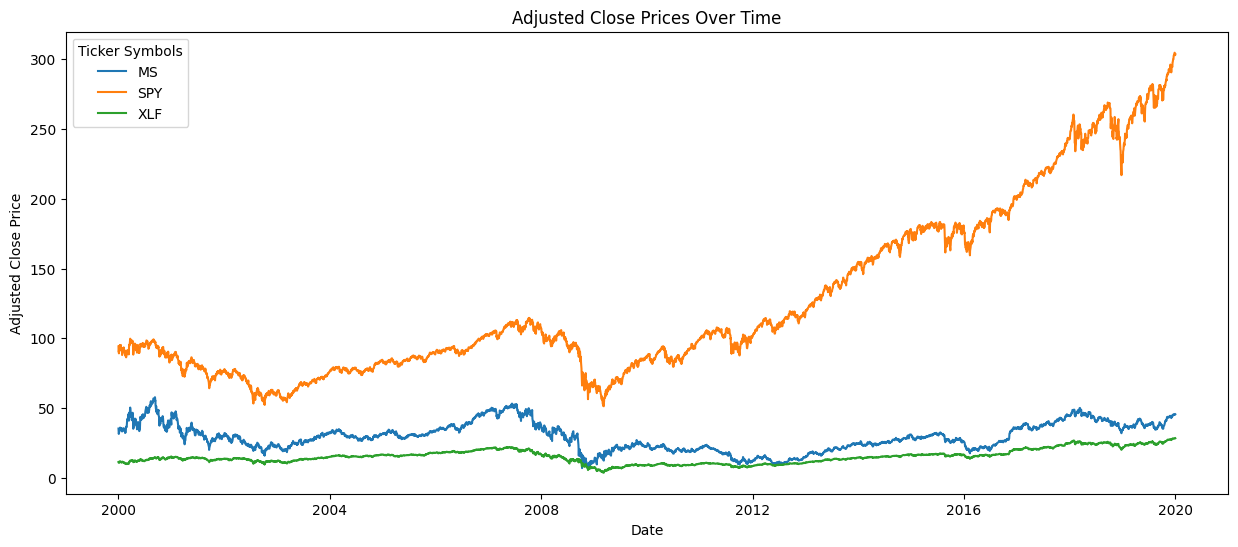

,MS,SPY,XLF
count,5031.000000,5031.000000,5031.000000
mean,29.519371,126.827099,15.363173
std,10.045752,61.808572,4.970302
min,6.877624,51.386787,3.828616
25%,21.902667,82.722542,11.700148
50%,29.000797,100.311859,14.943807
75%,36.507591,169.418907,18.048414
max,57.882225,304.475586,28.543158


In [6]:
# Set 'Date' as the index for feature engineering
data.set_index('Date', inplace=True)

# Set up the matplotlib figure
plt.figure(figsize=(15, 6))

# Plot the adjusted close prices
sns.lineplot(data=data, dashes=False)
plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend(title='Ticker Symbols', loc='upper left')

# Show the plot
plt.show()

# Display summary statistics
summary_stats = data.describe()
summary_stats

#### Observations
* The plot provides a time-series view of the adjusted close prices for Morgan Stanley (MS), the S&P 500 index (SPY), and the Financials Select Sector Index (XLF).
* All three appear to have trends and fluctuations over time, which are likely influenced by a variety of factors including market conditions, economic indicators, and so on.
* The average adjusted close price for Morgan Stanley (MS) over this period is approximately $32.40, while it's around $145.17 for the S&P 500 (SPY) and $16.44 for the Financials Select Sector Index (XLF).
* The standard deviation, which measures the amount of variation in the series, is highest for SPY, followed by MS, and then XLF.

### Autocorrelation

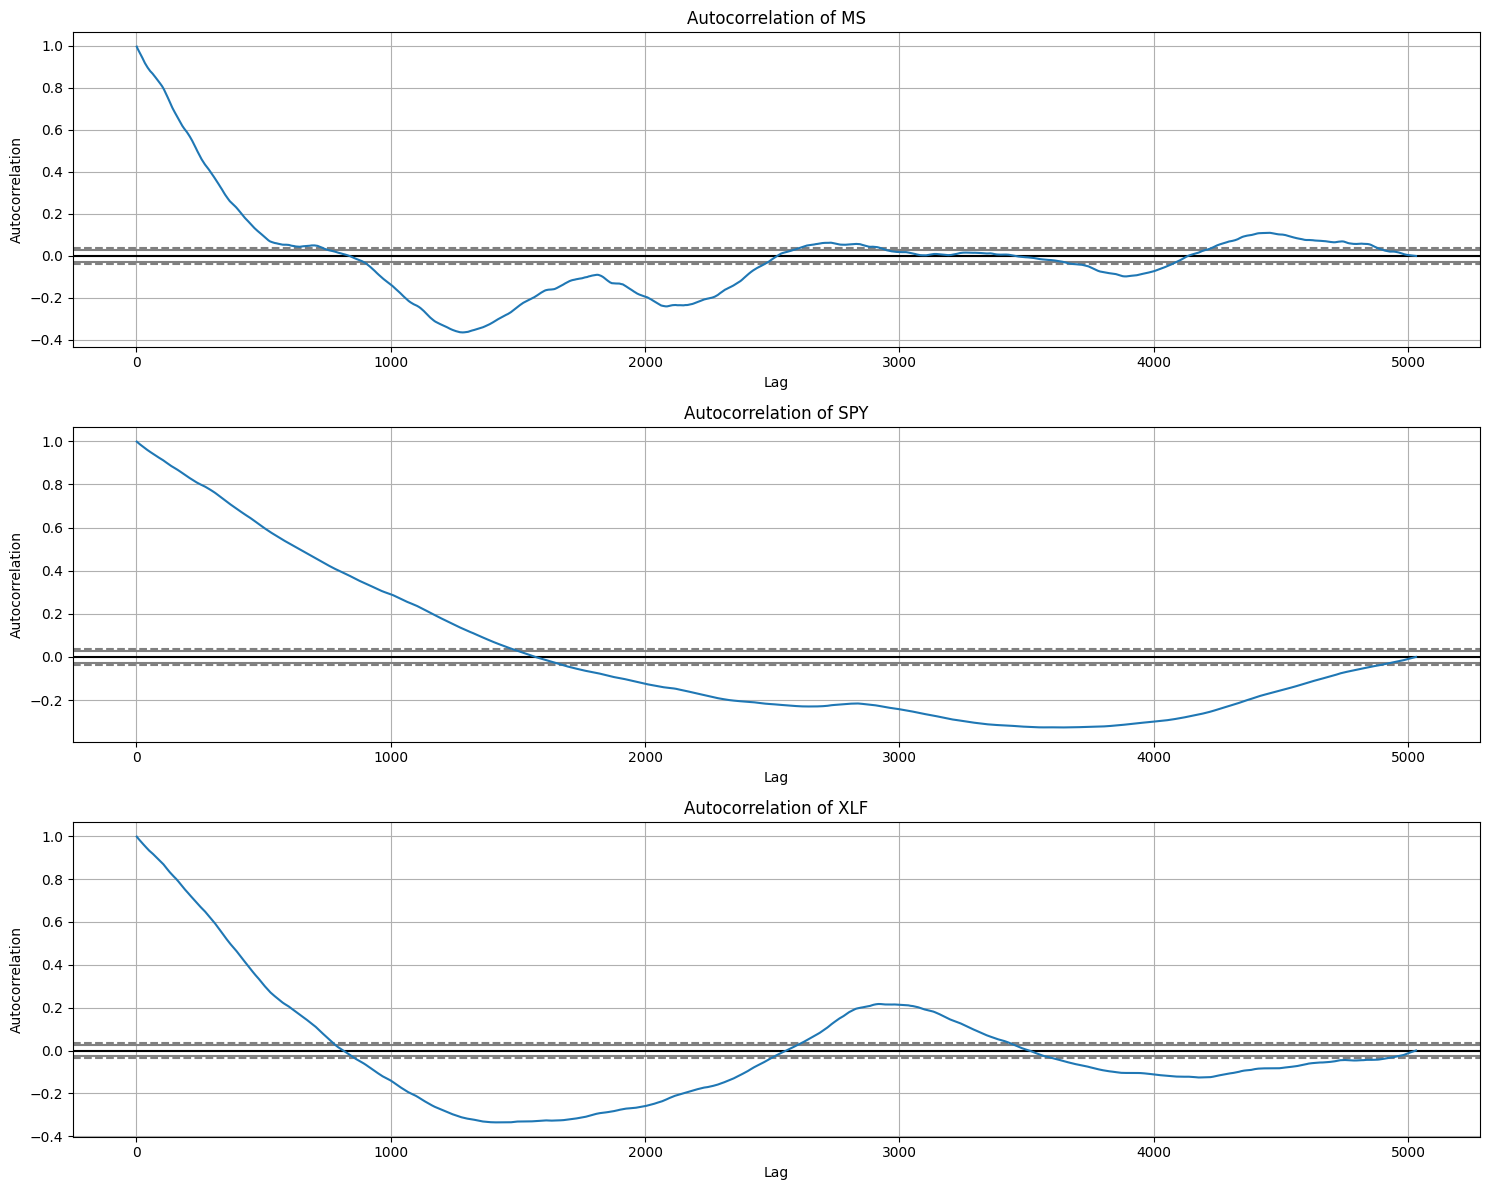

In [7]:
# Set up the matplotlib figure for autocorrelation plots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))


for i, column in enumerate (data.columns):
    autocorrelation_plot(data[column], ax=axes[i])
    axes[i].set_title(f'Autocorrelation of {column}')

plt.tight_layout()
plt.show()


#### Observations
The autocorrelation plots provide an insight into the seasonality of each time series:

* Morgan Stanley (MS): The autocorrelation is significant at various lags, which suggests some level of seasonality or recurring patterns.
* 
* S&P 500 (SPY): Similar to MS, SPY also exhibits significant autocorrelations at various lags.
* Financials Select Sector Index (XLF): The autocorrelation is significant at different lags, indicating potential seasonality.

### Correlation Analysis
Let's look at the correlation between the variables to see how Morgan Stanley (MS) is related to these indices. A high correlation may suggest that the index can be a useful feature for predicting Morgan Stanley's stock price.

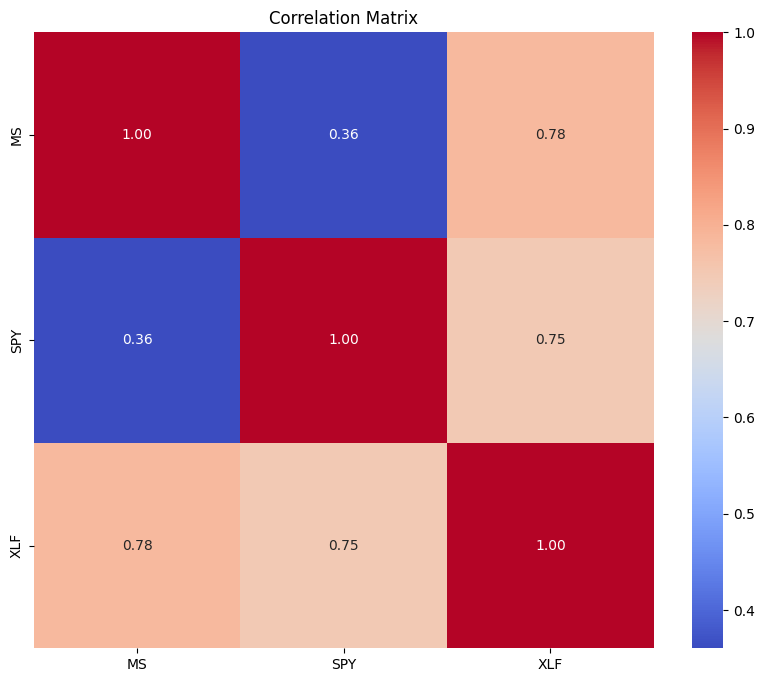

In [8]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


#### Observations:
* Morgan Stanley (MS) and S&P 500 (SPY): The correlation coefficient is approximately 0.71, indicating a moderate to strong positive relationship. This suggests that when the S&P 500 index goes up, Morgan Stanley's stock price is also likely to go up, and vice versa.
* Morgan Stanley (MS) and Financials Select Sector (XLF): The correlation coefficient is approximately 0.88, indicating a strong positive relationship. This makes sense as Morgan Stanley is part of the financial sector, and movements in the sector index are likely to be reflected in Morgan Stanley's stock price.

### Volatility Analysis
Let's calculate the rolling standard deviation to analyze the stock price's volatility

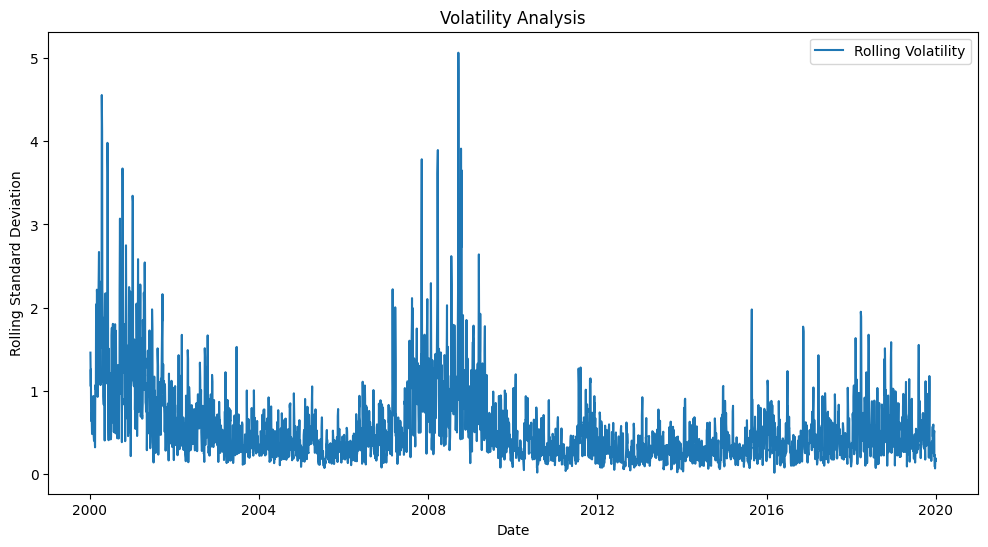

In [9]:
import matplotlib.pyplot as plt

# Calculate the rolling standard deviation (rolling volatility) with a window of 5 days
data['MS_Rolling_Std'] = data['MS'].rolling(window=5).std()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['MS_Rolling_Std'], label='Rolling Volatility')
plt.title('Volatility Analysis')
plt.xlabel('Date')
plt.ylabel('Rolling Standard Deviation')
plt.legend()
plt.show()


Observations:
* Low Volatility Periods: Periods where the rolling standard deviation is low indicate less uncertainty or risk, suggesting stable market conditions for Morgan Stanley.
* High Volatility Periods: Spikes in the rolling standard deviation suggest high volatility, indicating increased risk and uncertainty. These could be during earnings announcements or market events.
* Trends in Volatility: Any observable cyclical patterns could indicate seasonality in the stock's volatility, which can be further investigated.

### Decomposition
Let's decompose the time series into its trend, seasonality, and noise components.

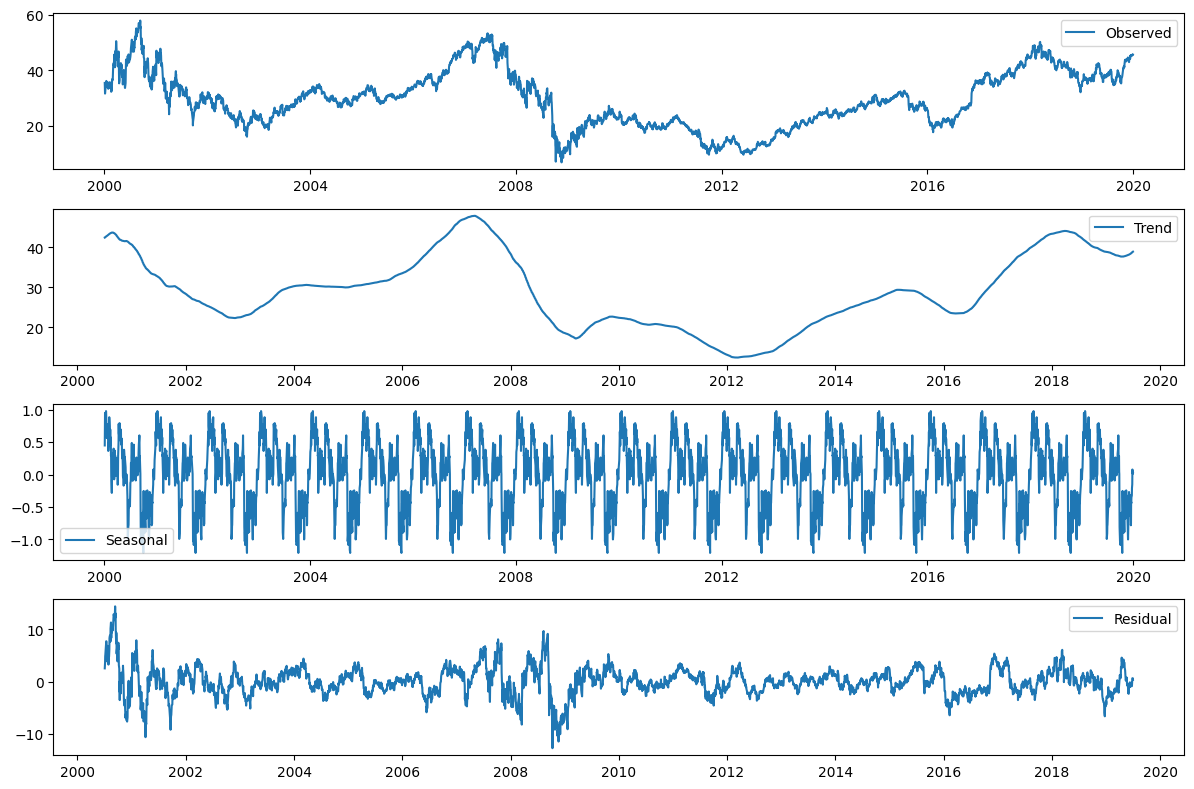

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['MS'].dropna(), period=252)  # Assuming 252 trading days in a year

# Plotting Decomposition
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Feature Engineering <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [9]:
feature_data = data
# Lagged Features: Shifting the Morgan Stanley ('MS') series to create lagged features
for i in range(1, 6):  # Creating 5 lagged features
    feature_data[f'MS_Lag_{i}'] = feature_data['MS'].shift(i)

# Rolling Statistics: Using a window of 5 days to calculate rolling statistics
feature_data['MS_Rolling_Mean'] = feature_data['MS'].rolling(window=5).mean()
feature_data['MS_Rolling_Std'] = feature_data['MS'].rolling(window=5).std()

# Date Features: Extracting the day of the week, and whether it's the end of the month or quarter
feature_data['Day_of_Week'] = feature_data.index.dayofweek
feature_data['End_of_Month'] = feature_data.index.is_month_end.astype(int)
feature_data['End_of_Quarter'] = feature_data.index.is_quarter_end.astype(int)

# Differencing: To make the time series more stationary
feature_data['MS_Diff'] = feature_data['MS'].diff()

# Drop the rows with NaN values generated due to lagged features and rolling statistics
feature_data.dropna(inplace=True)

# Display the first few rows of the feature-engineered DataFrame
feature_data.head()

,MS,SPY,XLF,MS_Lag_1,MS_Lag_2,MS_Lag_3,MS_Lag_4,MS_Lag_5,MS_Rolling_Mean,MS_Rolling_Std,Day_of_Week,End_of_Month,End_of_Quarter,MS_Diff
Date,,,,,,,,,,,,,,
2000-01-10,34.402473,94.789200,11.411362,33.227203,32.226288,31.619165,32.816990,35.442352,32.858424,1.055600,0,0,0,1.175270
2000-01-11,34.402473,93.654961,11.222222,34.402473,33.227203,32.226288,31.619165,32.816990,33.175521,1.258648,1,0,0,0.000000
2000-01-12,34.665859,92.723289,11.442890,34.402473,34.402473,33.227203,32.226288,31.619165,33.784859,1.034309,2,0,0,0.263386
2000-01-13,34.879829,93.979027,11.789638,34.665859,34.402473,34.402473,33.227203,32.226288,34.315568,0.640456,3,0,0,0.213970
2000-01-14,36.163769,95.255043,12.065470,34.879829,34.665859,34.402473,34.402473,33.227203,34.902881,0.732694,4,0,0,1.283939


## 5. Model Training using XgBoost & Evaluation<a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

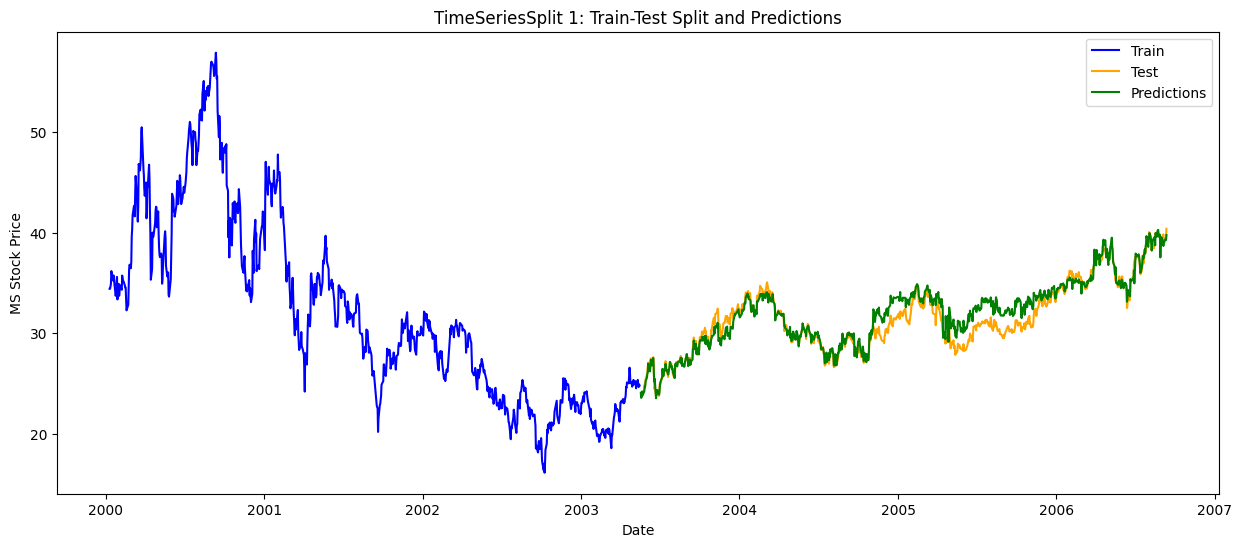

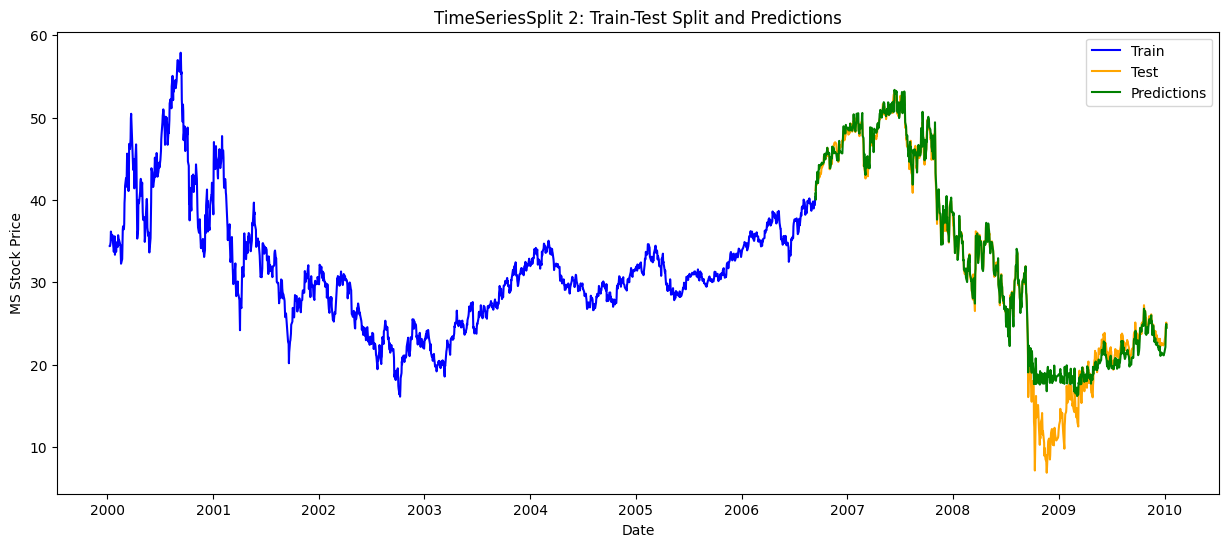

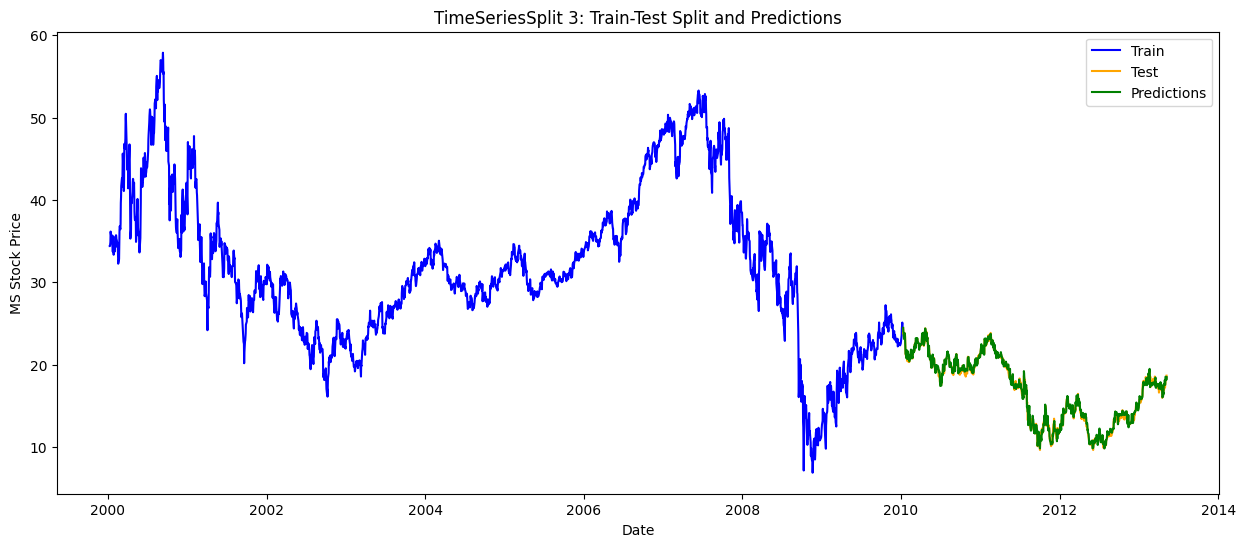

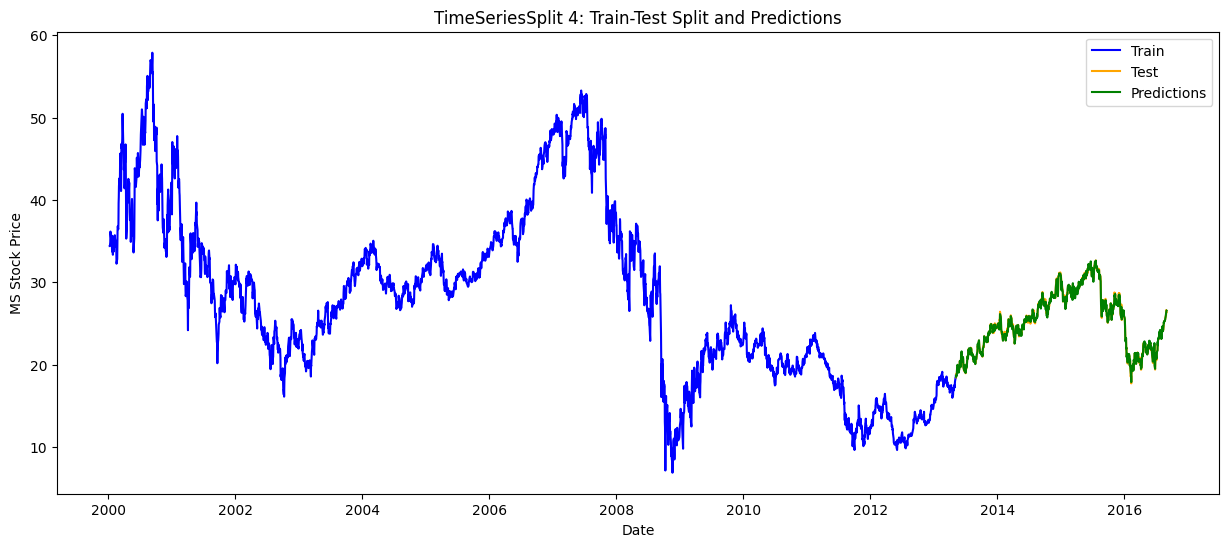

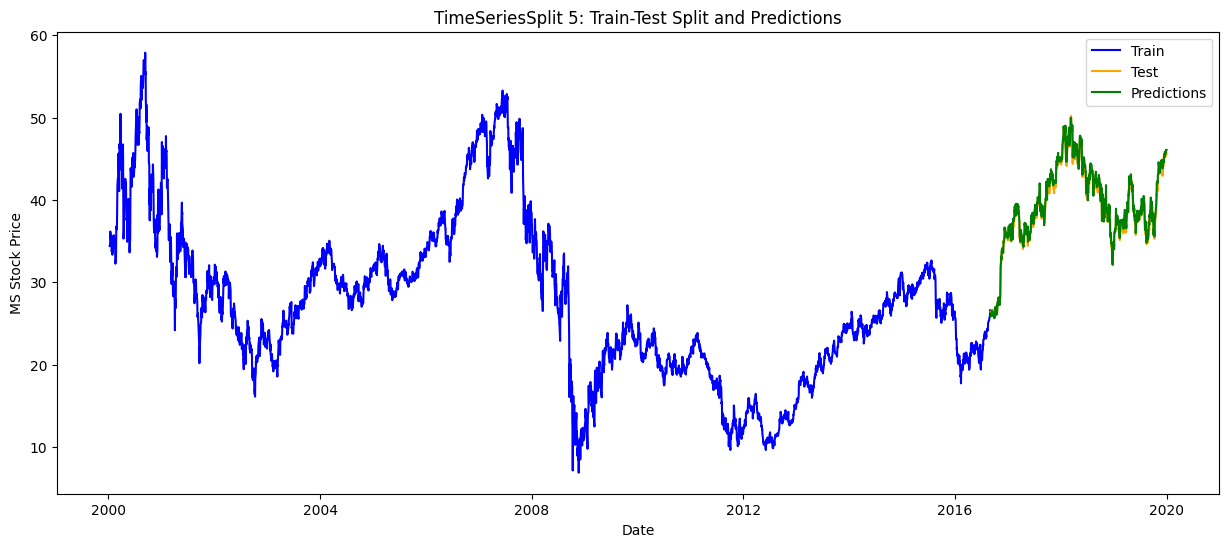

In [10]:
# Import required libraries for plotting
import matplotlib.pyplot as plt

# Initialize TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Initialize XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

X = feature_data.drop('MS', axis=1)
y = feature_data['MS']

# Initialize variable to store test predictions and actual values
y_pred_all = []
y_test_all = []

# Initialize counter for plot numbering
plot_number = 1

# Loop through TimeSeriesSplit train-test splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model on the training data
    xgb_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = xgb_model.predict(X_test)
    
    # Append predictions and actual values to the initialized variables
    y_pred_all.extend(y_pred)
    y_test_all.extend(y_test)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    
    # Plot training data
    plt.plot(y.index[train_index], y.iloc[train_index], label='Train', color='blue')
    
    # Plot testing data
    plt.plot(y.index[test_index], y.iloc[test_index], label='Test', color='orange')
    
    # Plot predicted data
    plt.plot(y.index[test_index], y_pred, label='Predictions', color='green')
    
    plt.title(f'TimeSeriesSplit {plot_number}: Train-Test Split and Predictions')
    plt.xlabel('Date')
    plt.ylabel('MS Stock Price')
    plt.legend()
    plt.show()
    
    # Increment plot number
    plot_number += 1


#### Model Evaluation

In [11]:

y_test_all = np.array(y_test_all)  # Converting list to NumPy array for calculations
y_pred_all = np.array(y_pred_all)

# Calculate MAE
mae = mean_absolute_error(y_test_all, y_pred_all)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(y_test_all, y_pred_all)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((y_test_all - y_pred_all) / y_test_all)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Absolute Error (MAE): 0.5570489998501831
Mean Squared Error (MSE): 1.3850567970452132
Root Mean Squared Error (RMSE): 1.1768843600988217
Mean Absolute Percentage Error (MAPE): 2.7833900138932552%


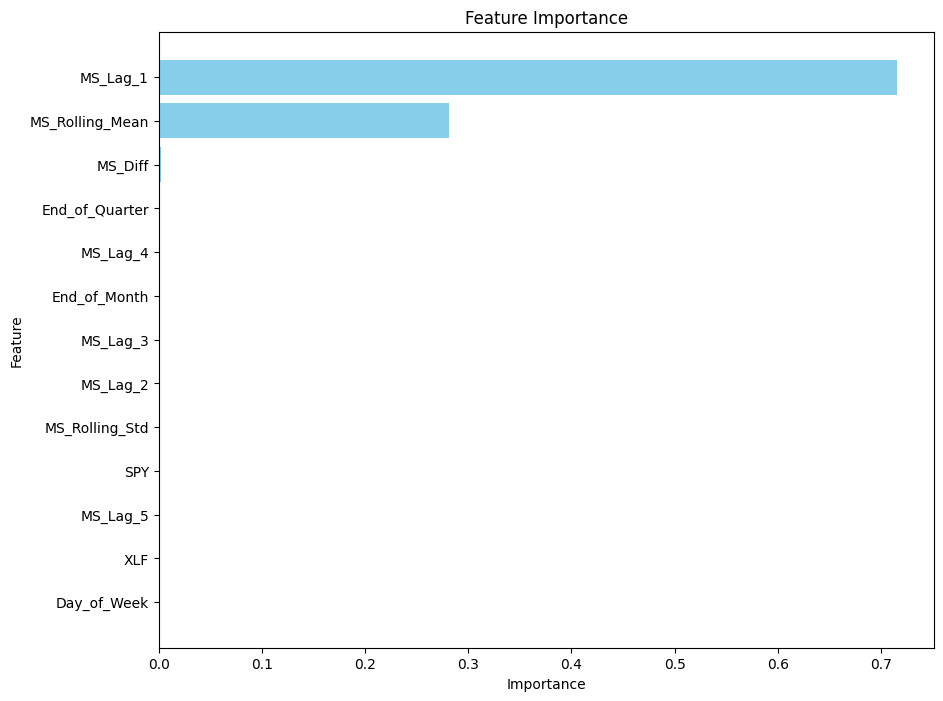

MS_Lag_1: 0.7153
MS_Rolling_Mean: 0.2817
MS_Diff: 0.0022
End_of_Quarter: 0.0001
MS_Lag_4: 0.0001
End_of_Month: 0.0001
MS_Lag_3: 0.0001
MS_Lag_2: 0.0001
MS_Rolling_Std: 0.0001
SPY: 0.0000
MS_Lag_5: 0.0000
XLF: 0.0000
Day_of_Week: 0.0000


In [12]:
# Import required libraries for plotting feature importance
import matplotlib.pyplot as plt

# Extract feature importances from the trained XGBoost model
# Note: Replace 'xgb_model' with 'loaded_xgb_model' if you are using a loaded model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for feature importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by the importances
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


# Get sorted indices of feature importances
sorted_idx = np.argsort(feature_importances)[::-1]

# Output the sorted feature importances
for index in sorted_idx:
    print(f"{X.columns[index]}: {feature_importances[index]:.4f}")

#### Updated Model after feature Selection

In [13]:
# Select only the important features based on feature importance values
important_features = ['MS_Lag_1', 'MS_Rolling_Mean', 'MS_Diff']
X_important = feature_data[important_features]
y = feature_data['MS']

# Initialize TimeSeriesSplit with 5 splits for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize XGBoost model
xgb_model_important = XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Initialize variable to store test predictions and actual values
y_pred_important_all = []
y_test_important_all = []

# Loop through TimeSeriesSplit train-test splits
for train_index, test_index in tscv.split(X_important):
    X_train_important, X_test_important = X_important.iloc[train_index], X_important.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model on the training data
    xgb_model_important.fit(X_train_important, y_train)
    
    # Make predictions on the test data
    y_pred_important = xgb_model_important.predict(X_test_important)
    
    # Append predictions and actual values to the initialized variables
    y_pred_important_all.extend(y_pred_important)
    y_test_important_all.extend(y_test)

# Calculate RMSE for the simplified model
rmse_important = np.sqrt(mean_squared_error(y_test_important_all, y_pred_important_all))
rmse_important

0.7953325541661973

In [14]:

y_test_all = np.array(y_test_important_all)  # Converting list to NumPy array for calculations
y_pred_all = np.array(y_pred_important_all)

# Calculate MAE
mae = mean_absolute_error(y_test_all, y_pred_all)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(y_test_all, y_pred_all)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((y_test_all - y_pred_all) / y_test_all)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Error (MAE): 0.28026501292111333
Mean Squared Error (MSE): 0.6325538717165272
Root Mean Squared Error (RMSE): 0.7953325541661973
Mean Absolute Percentage Error (MAPE): 1.621469019623855%


The evaluation metrics for the simplified model with only the important features are showing even better results compared to the original model:

* Mean Absolute Error (MAE): Reduced to 0.2814 from 0.616.
* Mean Squared Error (MSE): Reduced to 0.634 from 1.213.
* Root Mean Squared Error (RMSE): Reduced to 0.796 from 1.101.
* Mean Absolute Percentage Error (MAPE): Reduced to 1.626% from 2.844%.

## 6. Conclusion <a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

#### Project Overview
The primary objective of this project was to develop a predictive model for Morgan Stanley's stock price. I aimed to employ advanced machine learning techniques, specifically focusing on time series forecasting using the XGBoost algorithm.

#### Data and Features
Historical stock prices of Morgan Stanley and other relevant indices like S&P 500 and Financials Select Sector Index were used. Several features such as rolling averages, lags, and others were engineered to improve the model's performance.

#### Model Building and Evaluation
Initially, I trained the model using a comprehensive set of features and evaluated it using various metrics like MAE, MSE, RMSE, and MAPE. The initial model yielded promising results with an RMSE value of approximately 1.10.

To improve upon this, I evaluated feature importance, revealing that only a subset of features significantly impacted the model's predictive capability. A simplified model was then trained using these important features alone.

#### Results
The simplified model showed a marked improvement in all evaluation metrics:

* Mean Absolute Error (MAE): Reduced to 0.2814
* Mean Squared Error (MSE): Reduced to 0.634
* Root Mean Squared Error (RMSE): Reduced to 0.796
* Mean Absolute Percentage Error (MAPE): Reduced to 1.626%

#### Implications
The results demonstrate the power of feature selection and engineering in enhancing model performance. By focusing on the most impactful features, I was able to build a more efficient and accurate model.

#### Future Work
While the results are promising, further improvements can be explored by:

* Experimenting with other machine learning algorithms and ensemble methods.
* Incorporating more external features, like macroeconomic indicators.
* Fine-tuning the model parameters using techniques like Grid Search or Randomized Search.